In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import matplotlib
import random as rd
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
from scipy.optimize import minimize, NonlinearConstraint, BFGS
import itertools as it
import seaborn as sn

In [3]:
def count_permutationlist(df, d):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    for i in range(len(df)-d+1):
        slice_df = df[i:i+d]
        sort_slice = sorted(slice_df)
        for j in range(d):
            slice_df[slice_df.index(sort_slice[j])] = j
        count_p[perm.index(tuple(slice_df))] += 1
    return count_p
def count_permutation(df, d):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    for i in range(df.size-d+1):
        slice_df = df.copy().iloc[i:i+d]
        sort_slice = slice_df.copy().sort_values()
        for j in range(d):
            #print(slice_df[slice_df==sort_slice.iloc[j]])
            slice_df.replace(slice_df[slice_df==sort_slice.iloc[j]].item(), j, inplace = True)
        count_p[perm.index(tuple(slice_df.tolist()))] += 1
    return count_p
def entropy(perm:list):
    allperm = sum(perm)
    ent = 0
    for i in range(len(perm)):
        probability = perm[i]/allperm
        if probability !=0:
            ent -= probability * math.log2(probability)
    return ent

In [4]:
def fun(X, alp: float, beta: float, max_kf: float, trend: float, season: float):
    j = 2
    k = 2
    for i in X[2:]:
        X[i] = (alp * X[i-dt.timedelta(1/24)] + beta * X[i-dt.timedelta(2/24)]) + rd.uniform(-max_kf, max_kf) + trend * j
        if k%(7*24)==0:
            X[i]+=season
        if k%(7*24)==1:
            X[i]-=season
        k+=1
    return X

In [5]:
def walds_martingale(n, sigma, tetta):

    s = np.random.normal(0, np.sqrt(sigma), n)  

    z=np.cumsum(s)
    
    #rand_val = [rd.normalvariate(0, sigma) for i in range(n)]
    for i in range(len(z)):
        z[i] = np.exp(tetta * z[i] - 0.5 * tetta**2 *i)
    return z
    

In [6]:
walds_martingale(500, 20, 0.01)

array([0.99323112, 0.91827083, 0.9441152 , 0.94605693, 0.98976503,
       0.92504816, 0.94590597, 0.9853185 , 0.96793926, 0.98182473,
       0.88616007, 0.9084325 , 0.88969298, 0.8396862 , 0.90029027,
       0.9480759 , 0.95771381, 0.92172608, 0.96643661, 0.97827757,
       1.04554765, 1.03821216, 0.97013085, 0.94943254, 0.9739166 ,
       0.95189193, 0.95374011, 0.97072799, 0.96714238, 0.98131658,
       0.95517544, 1.02401386, 1.03520631, 1.0504951 , 1.03740776,
       1.01318282, 0.96150801, 0.90680909, 0.94635476, 0.91820012,
       0.89914118, 0.89954994, 0.87280792, 0.82448104, 0.86984823,
       0.85032737, 0.88876294, 0.92686197, 0.9353251 , 0.94140881,
       0.86508584, 0.82325333, 0.89238943, 0.80728517, 0.78510671,
       0.72395891, 0.70283439, 0.69484564, 0.6864944 , 0.66957555,
       0.70429833, 0.70006145, 0.70308104, 0.63634093, 0.60898051,
       0.63787254, 0.67033836, 0.69165419, 0.7023085 , 0.69209027,
       0.72755769, 0.7762533 , 0.77739823, 0.80354527, 0.83820

<AxesSubplot:>

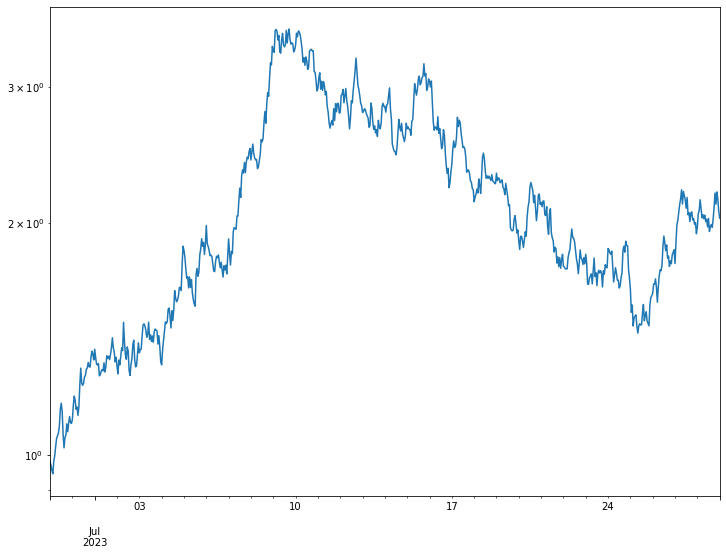

In [37]:
datelist = pd.date_range(start='29/06/2023 00:00:00', end='29/07/2023', freq='H').to_series()
datelist.index = datelist
datelist['29/06/2023 00:00:00'] = 5000.0
datelist['29/06/2023 01:00:00'] = 5015.0
ts = pd.Series(walds_martingale(datelist.shape[0], 2, 0.02), index = datelist.index)
ts.plot(figsize=(12,9),logy=True)

In [110]:
def iqr(x):
    quartiles = pd.Series(x).quantile([0.25, 0.75])
    return quartiles[0.75] - quartiles[0.25]

In [112]:
wald_list = []
ts_list = []
rd_walk_list = []
for i in range(50):
    print(i)
    rd_walk_list.append(entropy(count_permutation(fun(datelist.copy(), 1, 0, 50, 0, 0),7)))
    ts_list.append(entropy(count_permutation(fun(datelist.copy(), 0.4501, 0.5483, 15, 2, 0), 7)))
    wald_list.append(entropy(count_permutation(pd.Series(walds_martingale(datelist.shape[0], 2, 0.02), index = datelist.index),7)))
print("Mean Wald's martingale: ",np.mean(wald_list))
print("Mean ts: ",np.mean(ts_list))
print("Mean rd_walk: ",np.mean(rd_walk_list))
print("IQR Wald's martingale: ", iqr(wald_list))
print("IQR ts: ", iqr(ts_list))
print("IQR rd_walk: ", iqr(rd_walk_list))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Mean Wald's martingale:  8.803813060081108
Mean ts:  8.93908676124485
Mean rd_walk:  8.773826852777974
IQR Wald's martingale:  0.08228343269480654
IQR ts:  0.11851554313399681
IQR rd_walk:  0.11908993888016539


noise ent: 9.353813732359113

Проверим, что это мартингейл

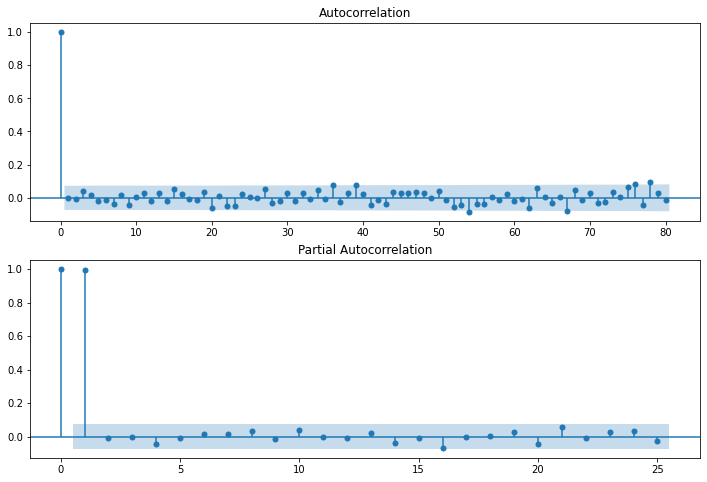

In [38]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.diff(periods=1).dropna().values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=25, ax=ax2)

In [39]:
src_data_model = ts[:'2023-07-17 00:00:00']
src_data_model

2023-06-29 00:00:00    0.980031
2023-06-29 01:00:00    0.968878
2023-06-29 02:00:00    0.954657
2023-06-29 03:00:00    0.945160
2023-06-29 04:00:00    0.981265
                         ...   
2023-07-16 20:00:00    2.354004
2023-07-16 21:00:00    2.221263
2023-07-16 22:00:00    2.254149
2023-07-16 23:00:00    2.328653
2023-07-17 00:00:00    2.381640
Length: 433, dtype: float64

In [40]:
model = sm.tsa.ARIMA(src_data_model.astype(float), order=(1,0,0)).fit()

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  war

In [41]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  433
Model:                     ARMA(1, 0)   Log Likelihood                 552.185
Method:                       css-mle   S.D. of innovations              0.067
Date:                Thu, 30 Nov 2023   AIC                          -1098.371
Time:                        23:09:11   BIC                          -1086.159
Sample:                    06-29-2023   HQIC                         -1093.550
                         - 07-17-2023                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9134      0.604      3.166      0.002       0.729       3.098
ar.L1.y        0.9964      0.003    314.101      0.000       0.990       1.003
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0036           +0.0000j            1.0036            0.0000
-----------------------------------------------------------------------------
"""

In [42]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.015122  0.902130
1    0.018862  0.990613
2    0.458767  0.927852
3    0.523185  0.971205
4    0.607900  0.987639
5    0.608042  0.996265
6    1.075138  0.993524
7    1.298430  0.995571
8    1.557856  0.996694
9    1.562303  0.998728
10   2.230467  0.997509
11   2.252985  0.998908
12   3.039855  0.997787
13   3.060764  0.998962
14   4.880539  0.993090
15   4.907021  0.996196
16   4.914227  0.998003
17   5.070132  0.998747
18   5.350174  0.999072
19   6.892318  0.997024
20   6.898154  0.998334
21   6.904713  0.999085
22   8.164810  0.998088
23   8.292995  0.998764
24   8.316390  0.999289
25   8.475245  0.999533
26   9.111896  0.999490
27   9.149414  0.999704
28   9.155119  0.999836
29   9.643084  0.999846
30  10.461205  0.999795
31  10.475974  0.999883
32  10.871216  0.999901
33  11.841828  0.999850
34  12.004739  0.999899
35  13.990389  0.999641
36  14.595700  0.999642
37  14.768962  0.999749
38  15.787083  0.999653
39  16.184138  0.999708


D:\Programs\Anac\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [43]:
pred = model.predict('2023-07-17 00:00:00','2023-07-29 00:00:00', typ='levels')
trn = ts['2023-07-17 00:00:00':]
r2 = r2_score(trn, pred)
print ('R^2: %1.2f' % r2)

R^2: -0.49


D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:>

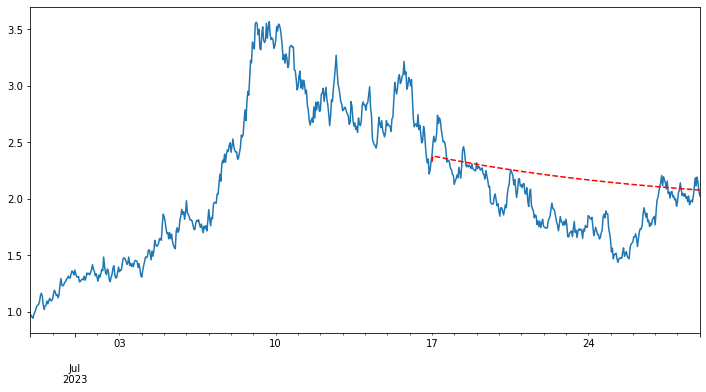

In [44]:
ts.plot(figsize=(12,6))
pred.plot(style='r--')